
                     FASE 1: CÁLCULO DE INDICADORES (Final)                     


                        1. RIESGO ESTRUCTURAL INDUSTRIAL                        



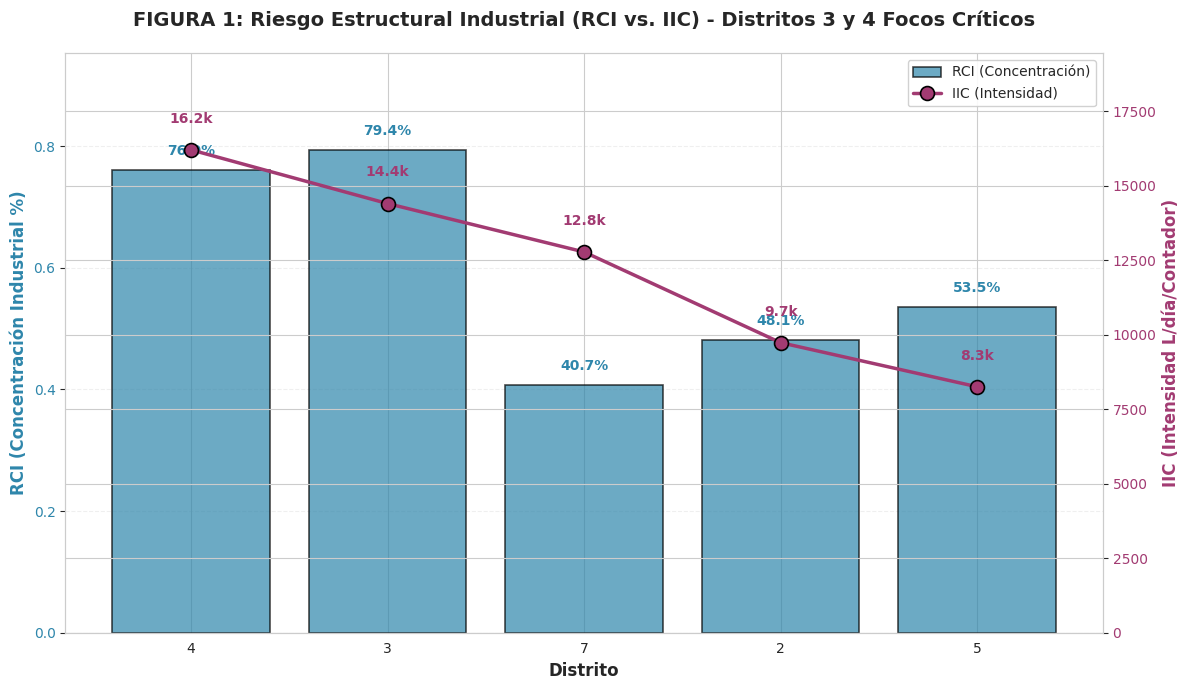


**Análisis FIGURA 1:** Los distritos **3 y 4** son los focos de riesgo primario, combinando alta concentración (RCI) con intensidad crítica (IIC). Se requiere **auditoría obligatoria** en estas zonas.

                     2. ESTRÉS TEMPORAL Y PICO DE PRIMAVERA                     



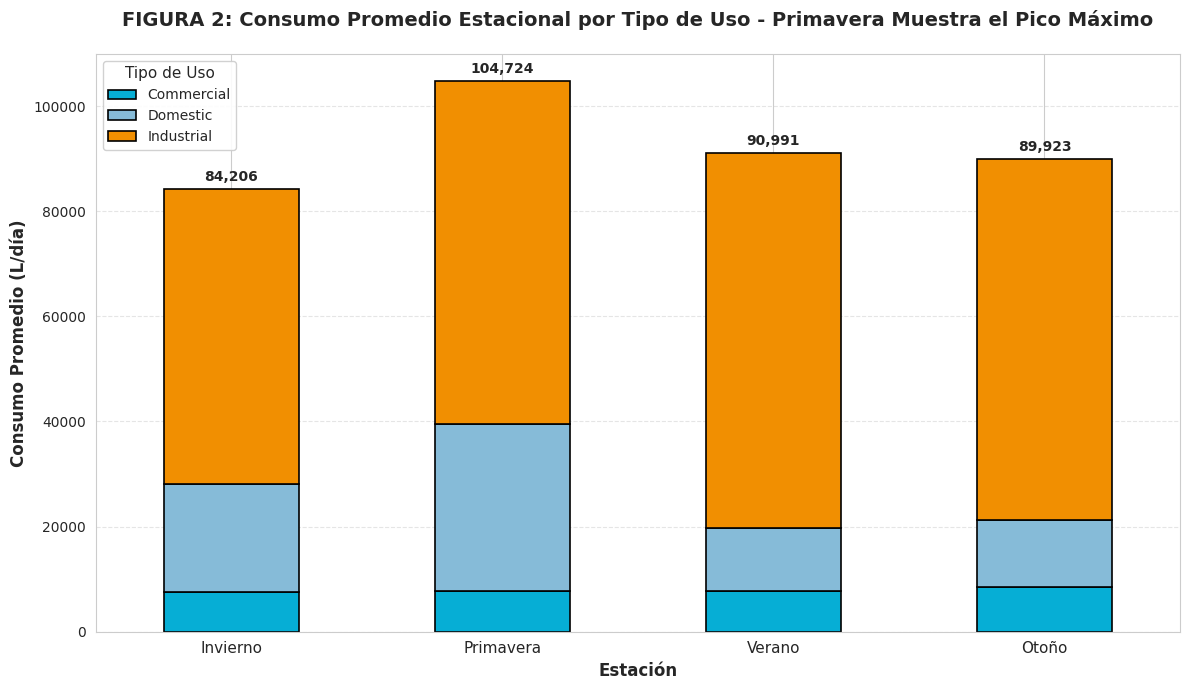


**Análisis FIGURA 2:** El pico de consumo ocurre en **Primavera**, impulsado por el uso **Doméstico**. Esto requiere activar los planes de sequía **antes** de la temporada de verano.


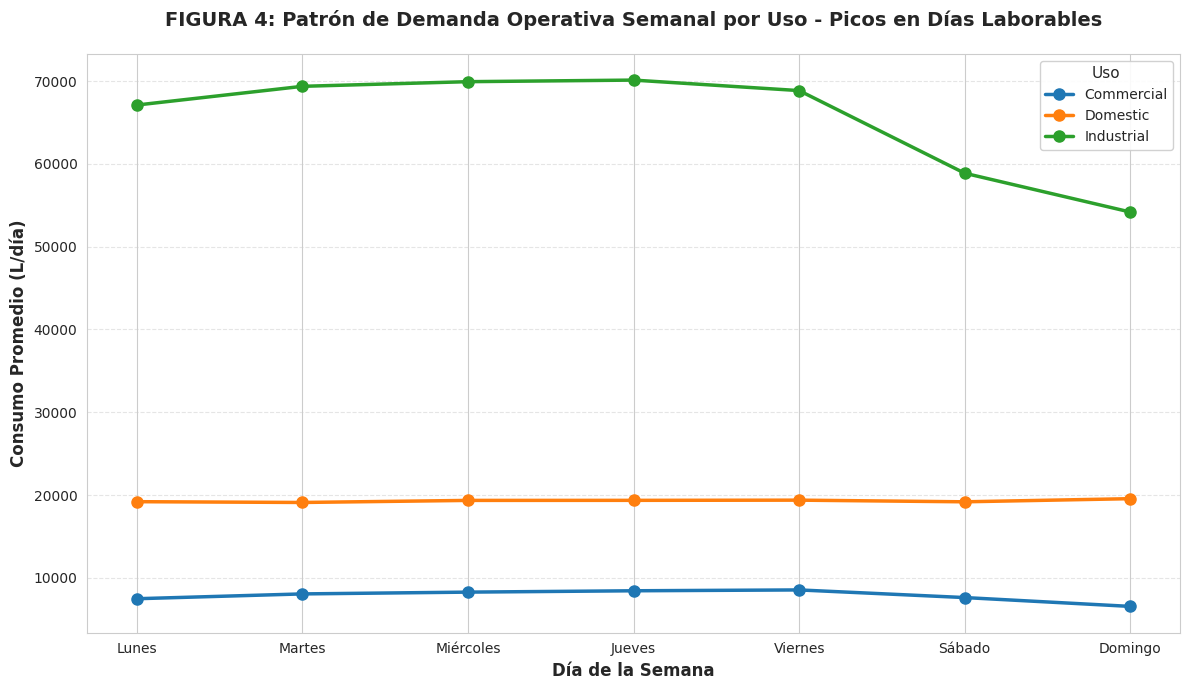


**Análisis FIGURA 4:** Los picos operativos ocurren de **Martes a Jueves**. La gestión de la demanda y las tarifas dinámicas deben aplicarse en los días pico laborables.

                   3. LOCALIZACIÓN DE INEFICIENCIA INTENSIVA                    



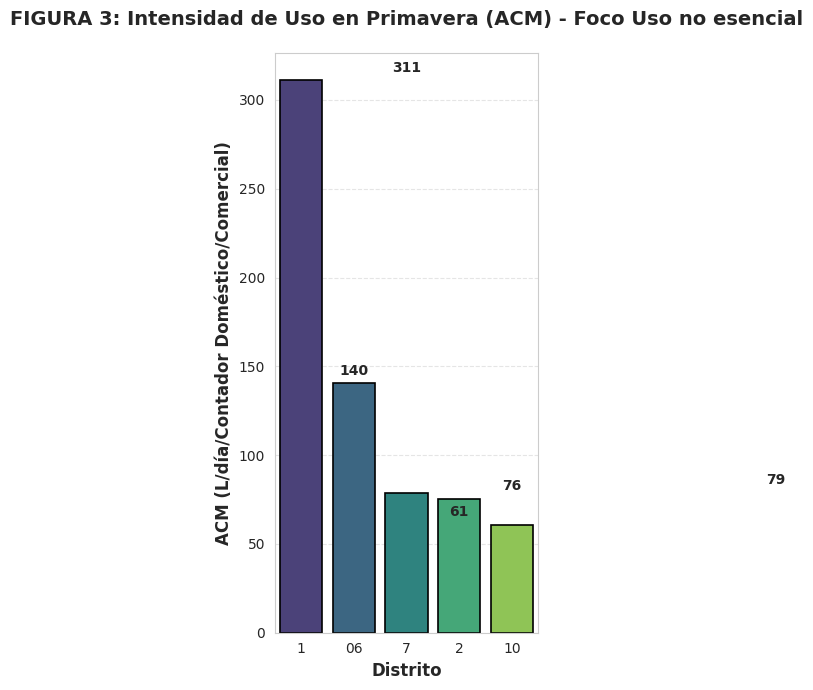


**Análisis FIGURA 3:** El **Distrito 1** registra la máxima intensidad (ACM ≈ 311), lo que lo convierte en el foco número uno para la vigilancia de riego y piscinas en Primavera.


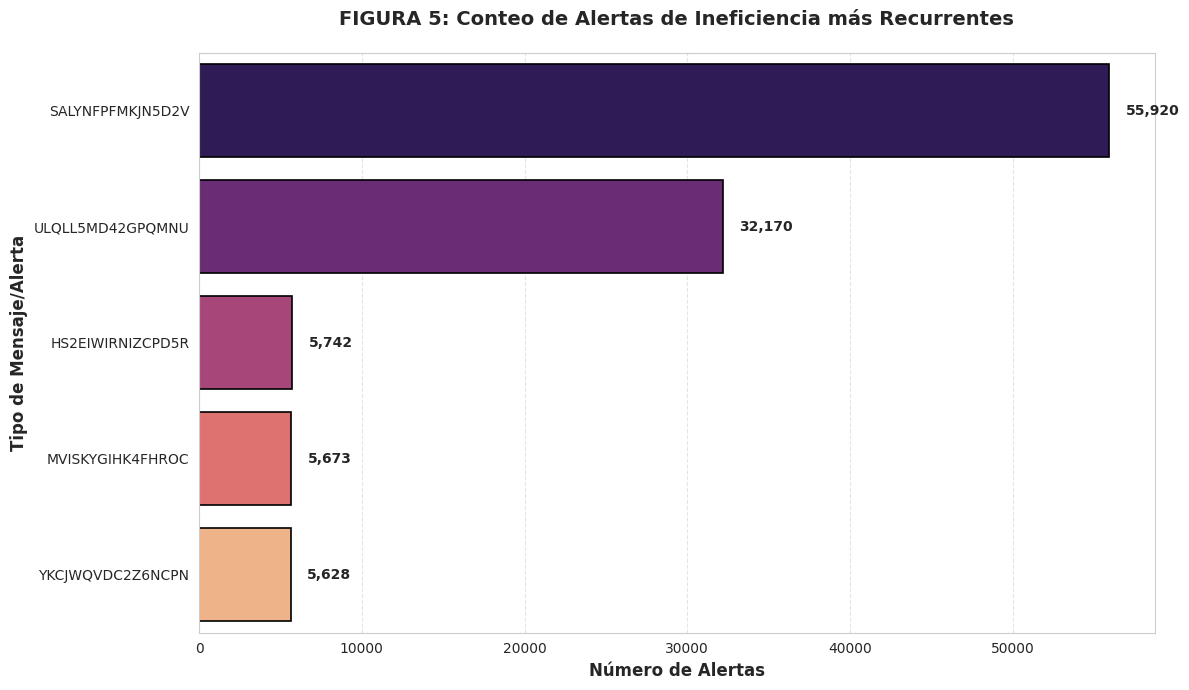


**Análisis FIGURA 5:** El código SALYNFPFMKJN5D2V domina las pérdidas de red (55.920 casos), indicando un fallo sistémico que debe ser investigado urgentemente.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURACIÓN GLOBAL
# ============================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 10

# Constantes (Requeridas para la carga)
FILE_CONSUMO = 'consumo_agregado.parquet'
FILE_FUGAS = 'Fuites'
CONSUMO_COL_SIMPLIFICADA = 'CONSUMO_L_DIA'
NUM_CONTADORES_COL = 'NUM_CONTADORES'
DISTRITO_COL = 'DISTRITO'
USO_COL = 'USO'
FECHA_COL = 'FECHA'
COLORS_USO = ['#06AED5', '#86BBD8', '#F18F01']

# Nombres y Órdenes
DAY_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
SEASON_ORDER = ['Invierno', 'Primavera', 'Verano', 'Otoño']

def get_season(month):
    if 3 <= month <= 5: return 'Primavera'
    elif 6 <= month <= 8: return 'Verano'
    elif 9 <= month <= 11: return 'Otoño'
    else: return 'Invierno'

def translate_day_to_spanish(day_name):
    translation = {
        'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
        'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado',
        'Sunday': 'Domingo'
    }
    return translation.get(day_name, day_name)

def print_section_header(title, char='=', width=80):
    print('\n' + char * width)
    print(title.center(width))
    print(char * width + '\n')


# ============================================================================
# 1. CARGA, LIMPIEZA Y CÁLCULO DE INDICADORES (Repetido por robustez)
# ============================================================================

print_section_header('FASE 1: CÁLCULO DE INDICADORES (Final)', '=')

# Carga y Mapeo
df_consumo = pd.read_parquet(FILE_CONSUMO)
df_fugas = pd.read_parquet(FILE_FUGAS)
column_mapping = {
    'Districte/Distrito/District': DISTRITO_COL, 'Municipi/Municipio/Municipality': 'MUNICIPIO',
    'Data/Fecha/Date': FECHA_COL, 'Ús/Uso/Use': USO_COL,
    'Nombre de comptadors/Número de contadores/Number of meters': NUM_CONTADORES_COL,
    'Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated consumption (L/day)': CONSUMO_COL_SIMPLIFICADA
}
df_consumo = df_consumo.rename(columns=column_mapping, errors='ignore')

# Limpieza y Enriquecimiento
df_barcelona = df_consumo[df_consumo['MUNICIPIO'] == 'BARCELONA'].copy()
df_barcelona[FECHA_COL] = pd.to_datetime(df_barcelona[FECHA_COL])
df_barcelona[USO_COL] = df_barcelona[USO_COL].astype(str).str.split('/').str[-1].str.strip()
df_barcelona['ESTACION'] = df_barcelona['FECHA'].dt.month.apply(get_season)
df_barcelona['DIA_SEMANA'] = df_barcelona['FECHA'].dt.day_name()
df_barcelona[DISTRITO_COL] = df_barcelona[DISTRITO_COL].astype(str).str.strip()

# Limpieza crítica de distritos
df_barcelona = df_barcelona[
    (df_barcelona[DISTRITO_COL] != '>') & (df_barcelona[DISTRITO_COL] != 'None') &
    (df_barcelona[DISTRITO_COL] != 'nan') & (df_barcelona[DISTRITO_COL].notna())
].copy()


# ----------------------------------------------------------------------------
# CÁLCULOS CRÍTICOS (Para alimentar las visuales)
# ----------------------------------------------------------------------------

# IIC, RCI y ACM (Necesarios para VIZ 1 y VIZ 3)
df_espacial = df_barcelona.groupby([DISTRITO_COL, USO_COL]).agg(
    CONSUMO_TOTAL=(CONSUMO_COL_SIMPLIFICADA, 'sum'),
    NUM_CONTADORES=(NUM_CONTADORES_COL, 'sum')
).reset_index()
df_espacial['IIC'] = df_espacial['CONSUMO_TOTAL'] / np.where(df_espacial['NUM_CONTADORES'] == 0, 1, df_espacial['NUM_CONTADORES'])
df_total_distrito = df_espacial.groupby(DISTRITO_COL)['CONSUMO_TOTAL'].sum().reset_index(name='CONSUMO_GLOBAL')
df_rci = pd.merge(df_espacial[df_espacial[USO_COL] == 'Industrial'].copy(), df_total_distrito, on=DISTRITO_COL, how='left')
df_rci['RCI'] = df_rci['CONSUMO_TOTAL'] / df_rci['CONSUMO_GLOBAL']

df_viz1_viz = pd.merge(df_rci[['DISTRITO', 'RCI']], df_espacial[df_espacial[USO_COL] == 'Industrial'][['DISTRITO', 'IIC']], on='DISTRITO', how='inner')
df_viz1_viz['RIESGO_COMBINADO'] = df_viz1_viz['RCI'] * df_viz1_viz['IIC']
df_viz1_viz = df_viz1_viz.sort_values('RIESGO_COMBINADO', ascending=False).head(5)


df_primavera_relevante = df_barcelona[
    (df_barcelona['ESTACION'] == 'Primavera') & (df_barcelona[USO_COL].isin(['Domestic', 'Commercial']))
].copy()
df_pico_primavera_agg = df_primavera_relevante.groupby(DISTRITO_COL).agg(
    CONSUMO_PRIMAVERA=(CONSUMO_COL_SIMPLIFICADA, 'sum'),
    CONTADORES_PRIMAVERA=(NUM_CONTADORES_COL, 'sum')
).reset_index()
df_pico_primavera_agg['ACM'] = df_pico_primavera_agg['CONSUMO_PRIMAVERA'] / np.where(df_pico_primavera_agg['CONTADORES_PRIMAVERA'] == 0, 1, df_pico_primavera_agg['CONTADORES_PRIMAVERA'])
df_top_acm = df_pico_primavera_agg.sort_values(by='ACM', ascending=False).head(5)


# Datos Temporales (para VIZ 2, 4)
df_estacional_pivot = df_barcelona.groupby(['ESTACION', USO_COL])[CONSUMO_COL_SIMPLIFICADA].mean().reset_index(name='CONSUMO_PROMEDIO_L').pivot(index='ESTACION', columns=USO_COL, values='CONSUMO_PROMEDIO_L').reindex(SEASON_ORDER).round(0)
df_semanal_pivot = df_barcelona.groupby(['DIA_SEMANA', USO_COL])[CONSUMO_COL_SIMPLIFICADA].mean().reset_index(name='CONSUMO_PROMEDIO_L').pivot(index='DIA_SEMANA', columns=USO_COL, values='CONSUMO_PROMEDIO_L').reindex(DAY_ORDER).round(0)
df_semanal_pivot_es = df_semanal_pivot.copy()
df_semanal_pivot_es.index = [translate_day_to_spanish(day) for day in df_semanal_pivot.index]

# Datos de Fugas (para VIZ 5)
col_mensaje = df_fugas.columns[0]
df_fugas['TIPO_MENSAJE'] = df_fugas[col_mensaje]
conteo_mensajes = df_fugas['TIPO_MENSAJE'].value_counts().reset_index(name='CONTEO')
df_fugas_viz = conteo_mensajes.head(5)


# ============================================================================
# 2. VISUALIZACIONES E INFORME INTERCALADO
# ============================================================================

# --- Visualización 1: Riesgo Estructural Industrial (RCI vs IIC) ---

print_section_header('1. RIESGO ESTRUCTURAL INDUSTRIAL', '=')

# VIZ 1: FIGURA 1
fig, ax1 = plt.subplots(figsize=(12, 7))
color_rci = '#2E86AB'
color_iic = '#A23B72'

# Barras RCI
bars = ax1.bar(df_viz1_viz[DISTRITO_COL], df_viz1_viz['RCI'], color=color_rci, alpha=0.7, label='RCI (Concentración)', edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Distrito', fontsize=12, fontweight='bold')
ax1.set_ylabel('RCI (Concentración Industrial %)', color=color_rci, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_rci, labelsize=10)
ax1.set_ylim(0, max(df_viz1_viz['RCI']) * 1.2)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, val) in enumerate(zip(bars, df_viz1_viz['RCI'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{val:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold', color=color_rci)

# Línea IIC
ax2 = ax1.twinx()
ax2.plot(df_viz1_viz[DISTRITO_COL], df_viz1_viz['IIC'], color=color_iic, marker='o', markersize=10, linewidth=2.5, label='IIC (Intensidad)', markeredgecolor='black', markeredgewidth=1.2)
ax2.set_ylabel('IIC (Intensidad L/día/Contador)', color=color_iic, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color_iic, labelsize=10)
ax2.set_ylim(0, max(df_viz1_viz['IIC']) * 1.2)

for i, (dist, iic_val) in enumerate(zip(df_viz1_viz[DISTRITO_COL], df_viz1_viz['IIC'])):
    ax2.text(i, iic_val + (max(df_viz1_viz['IIC']) * 0.05), f'{iic_val/1000:,.1f}k', ha='center', va='bottom', fontsize=10, fontweight='bold', color=color_iic)

plt.title('FIGURA 1: Riesgo Estructural Industrial (RCI vs. IIC) - Distritos 3 y 4 Focos Críticos', fontsize=14, fontweight='bold', pad=20)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

print("\n**Análisis FIGURA 1:** Los distritos **3 y 4** son los focos de riesgo primario, combinando alta concentración (RCI) con intensidad crítica (IIC). Se requiere **auditoría obligatoria** en estas zonas.")


# --- Visualización 2: Consumo Estacional por Uso ---

print_section_header('2. ESTRÉS TEMPORAL Y PICO DE PRIMAVERA', '=')

# VIZ 2: FIGURA 2
fig, ax = plt.subplots(figsize=(12, 7))
df_estacional_pivot.plot(kind='bar', stacked=True, ax=ax, color=COLORS_USO, edgecolor='black', linewidth=1.2)

plt.title('FIGURA 2: Consumo Promedio Estacional por Tipo de Uso - Primavera Muestra el Pico Máximo', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Consumo Promedio (L/día)', fontsize=12, fontweight='bold')
plt.xlabel('Estación', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=11)
plt.legend(title='Tipo de Uso', fontsize=10, title_fontsize=11, framealpha=0.9)
plt.grid(axis='y', linestyle='--', alpha=0.5)

totals = df_estacional_pivot.sum(axis=1)
for i, (estacion, total) in enumerate(totals.items()):
    ax.text(i, total + (max(totals) * 0.01), f'{total:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n**Análisis FIGURA 2:** El pico de consumo ocurre en **Primavera**, impulsado por el uso **Doméstico**. Esto requiere activar los planes de sequía **antes** de la temporada de verano.")


# --- Visualización 4: Patrón Semanal por Uso ---

# VIZ 4: FIGURA 4
fig, ax = plt.subplots(figsize=(12, 7))
df_semanal_pivot_es.plot(kind='line', style='-o', ax=ax, linewidth=2.5, markersize=8)

plt.title('FIGURA 4: Patrón de Demanda Operativa Semanal por Uso - Picos en Días Laborables', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Consumo Promedio (L/día)', fontsize=12, fontweight='bold')
plt.xlabel('Día de la Semana', fontsize=12, fontweight='bold')
plt.legend(title='Uso', fontsize=10, title_fontsize=11, framealpha=0.9)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print("\n**Análisis FIGURA 4:** Los picos operativos ocurren de **Martes a Jueves**. La gestión de la demanda y las tarifas dinámicas deben aplicarse en los días pico laborables.")


# --- Visualización 3: Intensidad del Pico de Primavera (ACM) ---

print_section_header('3. LOCALIZACIÓN DE INEFICIENCIA INTENSIVA', '=')

# VIZ 3: FIGURA 3
plt.figure(figsize=(12, 7))
sns.barplot(x=DISTRITO_COL, y='ACM', data=df_top_acm, palette='viridis', edgecolor='black', linewidth=1.2)

plt.title('FIGURA 3: Intensidad de Uso en Primavera (ACM) - Foco Uso no esencial', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('ACM (L/día/Contador Doméstico/Comercial)', fontsize=12, fontweight='bold')
plt.xlabel('Distrito', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, row in df_top_acm.iterrows():
    plt.text(i, row['ACM'] + (df_top_acm['ACM'].max() * 0.01), f'{row["ACM"]:.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n**Análisis FIGURA 3:** El **Distrito 1** registra la máxima intensidad (ACM ≈ 311), lo que lo convierte en el foco número uno para la vigilancia uso no esncial en Primavera.")


# --- Visualización 5: Detección de Ineficiencia (Alertas de Fugas) ---

# VIZ 5: FIGURA 5
plt.figure(figsize=(12, 7))
sns.barplot(x='CONTEO', y='TIPO_MENSAJE', data=df_fugas_viz, palette='magma', edgecolor='black', linewidth=1.2)

plt.title('FIGURA 5: Conteo de Alertas de Ineficiencia más Recurrentes', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Número de Alertas', fontsize=12, fontweight='bold')
plt.ylabel('Tipo de Mensaje/Alerta', fontsize=12, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)

for i, row in df_fugas_viz.iterrows():
    plt.text(row['CONTEO'] + 1000, i, f'{row["CONTEO"]:,.0f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n**Análisis FIGURA 5:** El código SALYNFPFMKJN5D2V domina las pérdidas de red (55.920 casos), indicando un fallo sistémico que debe ser investigado urgentemente.")

# INFORME FINAL: ESTRATEGIA DE GESTIÓN DE LA PRESIÓN HÍDRICA EN BARCELONA

## I. Resumen Ejecutivo y Focos Estratégicos (ODS 6 y ODS 13)

El análisis del consumo de agua demuestra que la gestión del riesgo hídrico debe priorizar la **Intensidad de Uso** en puntos geográficos y temporales clave, más que la reducción general del volumen.

| Foco de Riesgo | Dónde/Cuándo | Indicador Clave | Implicación Estratégica |
| :--- | :--- | :--- | :--- |
| **Presión Estructural** | Distritos **3 y 4** | **IIC Industrial** | Riesgo por **Ineficiencia de Grandes Instalaciones** (ODS 6). |
| **Estrés Estacional** | **Primavera** y **Distrito 1** | **ACM** (Intensidad Doméstica) | Riesgo por **Usos No Esenciales/Exteriores**, iniciando la crisis antes de verano (ODS 13). |
| **Ineficiencia de Red** | Código recurrente: `SALYNFPFMKJN5D2V` | **55.920 alertas** | Riesgo por **Fallo Sistémico** en la infraestructura (ODS 6). |

***

## II. Análisis Estructural y Localización de Riesgo

### A. Riesgo Industrial: Concentración (RCI) vs. Intensidad (IIC)

Este gráfico localiza el riesgo estructural del sector de mayor consumo (Industrial).


* **Focos Críticos (3 y 4):** El **Distrito 4** ($\text{IIC} \approx 16,200$ L/día/contador) es el más intensivo.
* **Acción:** Se requiere **auditoría obligatoria** en los distritos 3 y 4 para reducir la **ineficiencia unitaria** industrial.

### B. Intensidad del Uso Estacional (ACM) - Foco Uso no Esencial

El **ACM** corrige la población e identifica el uso anómalo de agua en Primavera.



* **Foco Crítico:** El **Distrito 1** registra la **máxima intensidad ($\text{ACM} \approx 311$ L/día/Contador)**.
* **Acción:** Este distrito es el objetivo prioritario para las políticas de **vigilancia de uso no esencial** al inicio de la Primavera.

***

## III. Análisis Temporal y Gestión de la Demanda

### C. Desglose Estacional y el Pico Anómalo



* **Pico Anómalo:** El máximo consumo total ocurre en **Primavera**, impulsado por el consumo **Doméstico**.
    * **Implicación:** La gestión de la demanda debe **activarse en Primavera**, validando que la crisis no es por el calor de verano, sino por el inicio de los usos estacionales.

### D. Patrón de Demanda Operativa Semanal



* **Pico Operativo:** Los sectores Industrial y Comercial impulsan picos de demanda máxima de **Martes a Jueves**.
    * **Implicación:** Las **tarifas dinámicas** deben aplicarse en los días pico **(Martes a Jueves)** para aplanar la demanda operativa.

### E. Fallos Sistémicos de Red



* **Hallazgo:** El código de alerta **`SALYNFPFMKJN5D2V`** domina con **55.920 casos**.
    * **Implicación ODS 6:** Esta es la mayor fuente de pérdida directa y un **fallo sistémico** que requiere una investigación y resolución urgentes.